## Bivariate Mixed Outcome Model: Poisson and Bernoulli VC Run-time and MSE Results 

In this example, $y_{i1} \sim Poisson(\mu_{i1}(\mathbf{\beta_1}))$ and $y_{i2} \sim Bernoulli(\mu_{i2}(\mathbf{\beta_2}))$

We simulate three fixed effects for each outcome, $\beta_1 \sim rand(p)$ and $\beta_2 \sim$ rand(Uniform(-0.2, 0.2), p) where p = 3 fixed effects.

In this example we have Poisson and Bernoulli base distribution with Log and Logit Link functions and covariance matrix $\Gamma$ structured under VC covariance with $\theta = 0.5$

We use multi-threading on 8 threads to obtain these MSE results on the following machine, and include MSE results from 100 simulation runs for each scenario.

In [1]:
versioninfo()

Julia Version 1.6.2
Commit 1b93d53fc4 (2021-07-14 15:36 UTC)
Platform Info:
  OS: macOS (x86_64-apple-darwin18.7.0)
  CPU: Intel(R) Core(TM) i9-9880H CPU @ 2.30GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-11.0.1 (ORCJIT, skylake)


In [2]:
using QuasiCopula, DelimitedFiles, LinearAlgebra, Random, GLM
using DataFrames

In [3]:
p  = 3    # number of fixed effects, including intercept

# true parameter values
Random.seed!(12345)
βtrue = rand(Uniform(-0.2, 0.2), 2 * p)
θtrue = [0.5]

# generate data
trueparams = [βtrue; θtrue] #hold true parameters

#simulation parameters
samplesizes = [100; 1000; 10000]
ns = [2]
nsims = 100;

In [4]:
@info "reading in the files with results"
fittimes = vec(readdlm("fittimes_bivariate_mixed_poisson_bernoulli_vcm$(nsims)reps_sim.csv", ','))

┌ Info: reading in the files with results
└ @ Main In[4]:1


300-element Vector{Float64}:
 0.060278604
 0.094576427
 0.05167295
 0.089687598
 0.051843549
 0.048932367
 0.053133853
 0.089689688
 0.048561383
 0.049339547
 0.09277155
 0.094785032
 0.049206822
 ⋮
 0.266598736
 0.284188311
 0.280211062
 0.262165824
 0.343498756
 0.306415833
 0.350078421
 0.287621688
 0.252897899
 0.278368838
 0.290401057
 0.272216576

In [5]:
#simulation parameters
@info "making results table"
sample_sizes = repeat(string.(samplesizes), inner = nsims * length(ns))
obs_sizes = repeat(string.(ns), inner = nsims, outer = length(samplesizes))

msedf = DataFrame(samplesize = sample_sizes, obssize = obs_sizes, fittimes = fittimes)
timedf = combine(groupby(msedf, [:samplesize, :obssize]), :fittimes => mean => :fittime,
    :fittimes => x -> (std(x)/sqrt(length(x))))
rename!(timedf, Dict(:fittimes_function => "se"))
timedf[!, :nobs] = Meta.parse.(timedf[!, :samplesize]) .* Meta.parse.(timedf[!, :obssize])
timedf[!, :fitmin] = timedf[!, :fittime] - timedf[!, :se]
timedf[!, :fitmax] = timedf[!, :fittime] + timedf[!, :se]
timedf[!, :perobsratio] = timedf[!, :fittime] ./ timedf[!, :nobs]
timedf

┌ Info: making results table
└ @ Main In[5]:2


,samplesize,obssize,fittime,se,nobs,fitmin,fitmax,perobsratio
,String,String,Float64,Float64,Int64,Float64,Float64,Float64
1,100,2,0.0696013,0.00243341,200,0.0671679,0.0720347,0.000348006
2,1000,2,0.0857167,0.00411187,2000,0.0816048,0.0898286,4.28584e-5
3,10000,2,0.29825,0.00401531,20000,0.294235,0.302266,1.49125e-5


In [6]:
######  supplementary table s1
using Random, DataFrames, DelimitedFiles, Statistics
import StatsBase: sem

βθcoverage = readdlm("beta_theta_coverage_bivariate_mixed_poisson_bernoulli_vcm$(nsims)reps_sim.csv", ',')

m = 1

covdf = DataFrame(Matrix(transpose(βθcoverage)), :auto)
rename!(covdf, Symbol.([["β$i" for i in 1:2p]; ["θ"]]))
covdf[!, :samplesize] = sample_sizes
covdf[!, :obssize] = obs_sizes
first(covdf, 10)

row_stats = [[(mean(col), sem(col)) for col = eachcol(d[!, 1:end-2])] for d = groupby(covdf, [:samplesize; :obssize])]
df = DataFrame(row_stats, :auto)
ss_obs = unique("N: " .* sample_sizes .* "  ni: " .* obs_sizes)
rename!(df, Symbol.(ss_obs))
covdfdisplay = DataFrame([[names(df)]; collect.(eachrow(df))], 
    [:people_obs; Symbol.([["β$i" for i in 1:2p]; ["θ"]])])
# deletecols!(covdfdisplay, p + 2)
covdfdisplay


,people_obs,β1,β2,β3,β4
,String,Tuple…,Tuple…,Tuple…,Tuple…
1,N: 100 ni: 2,"(0.64, 0.0482418)","(0.65, 0.0479372)","(0.65, 0.0479372)","(0.62, 0.0487832)"
2,N: 1000 ni: 2,"(0.74, 0.0440844)","(0.73, 0.0446196)","(0.6, 0.0492366)","(0.62, 0.0487832)"
3,N: 10000 ni: 2,"(0.73, 0.0446196)","(0.67, 0.0472582)","(0.62, 0.0487832)","(0.65, 0.0479372)"


In [7]:
#### 
#import data and reorganize to create figure
using Random, DataFrames, DelimitedFiles, Statistics, RCall, Printf
import StatsBase: sem

βMseresult_1 = vec(readdlm("mse_beta_bivariate_mixed_poisson_bernoulli_vcm$(nsims)reps_sim.csv", ','))
θMseResult_1 = vec(readdlm("mse_theta_bivariate_mixed_poisson_bernoulli_vcm$(nsims)reps_sim.csv", ','))
βθcoverage_1 = readdlm("beta_theta_coverage_bivariate_mixed_poisson_bernoulli_vcm$(nsims)reps_sim.csv", ',')

samplesizesrobust = samplesizes
nsrobust = ns
nsimsrobust = nsims

p = 3
sample_sizesrobust = repeat(string.(samplesizesrobust), inner = nsimsrobust * length(nsrobust))
obs_sizesrobust = repeat(string.(nsrobust), inner = nsimsrobust, outer = length(samplesizesrobust))
msedfrobust = DataFrame(βmse = βMseresult_1, thetamse = θMseResult_1,
    samplesize = sample_sizesrobust, obssize = obs_sizesrobust)


msedfrobustR = deepcopy(msedfrobust)
rename!(msedfrobustR, ["betamse"
    "thetamse"
    "samplesize"
 "obssize"]);

mses = [msedfrobustR[!, :betamse]; msedfrobustR[!, :thetamse]]
    # msedfnormR[!, :betamse]; msedfnormR[!, :taumse]; msedfnormR[!, :Sigmamse]]
obssize = collect([repeat(msedfrobustR[!, :obssize], 2)]...)

samplesize = collect([repeat(msedfrobustR[!, :samplesize], 2)]...) 

parameters = collect([repeat(string.([:beta, :theta]), inner = nsimsrobust * length(nsrobust) * length(samplesizesrobust))]...)
robust = collect([repeat(["Bivariate Mixed Poisson Bernoulli QC"], 2 * nsimsrobust * length(nsrobust) * length(samplesizesrobust))]...) # ;

msedfR = DataFrame(mse = mses, obssize = obssize, samplesize = samplesize,
    parameters = parameters, robust = robust)

#5 of the 30,000 simulations did not converge, filter out
msedfR = filter(x -> !isnan(x.mse), msedfR)
# additionally, there are 5 where an error was not caught so it did not try a differnt solver
msedfR = filter(x -> x.mse < 4000, msedfR)

,mse,obssize,samplesize,parameters,robust
,Float64,String,String,String,String
1,0.0948604,2,100,beta,Bivariate Mixed Poisson Bernoulli QC
2,0.0258412,2,100,beta,Bivariate Mixed Poisson Bernoulli QC
3,0.0361816,2,100,beta,Bivariate Mixed Poisson Bernoulli QC
4,0.0294433,2,100,beta,Bivariate Mixed Poisson Bernoulli QC
5,0.0115442,2,100,beta,Bivariate Mixed Poisson Bernoulli QC
6,0.0387927,2,100,beta,Bivariate Mixed Poisson Bernoulli QC
7,0.0538462,2,100,beta,Bivariate Mixed Poisson Bernoulli QC
8,0.0642697,2,100,beta,Bivariate Mixed Poisson Bernoulli QC
9,0.0379333,2,100,beta,Bivariate Mixed Poisson Bernoulli QC


┌ Warning: RCall.jl: Warning: package ‘scales’ was built under R version 4.0.2
└ @ RCall /Users/sarahji/.julia/packages/RCall/6kphM/src/io.jl:172
┌ Warning: RCall.jl: Warning: package ‘ggplot2’ was built under R version 4.0.2
└ @ RCall /Users/sarahji/.julia/packages/RCall/6kphM/src/io.jl:172
┌ Warning: RCall.jl: Warning: package ‘data.table’ was built under R version 4.0.2
└ @ RCall /Users/sarahji/.julia/packages/RCall/6kphM/src/io.jl:172


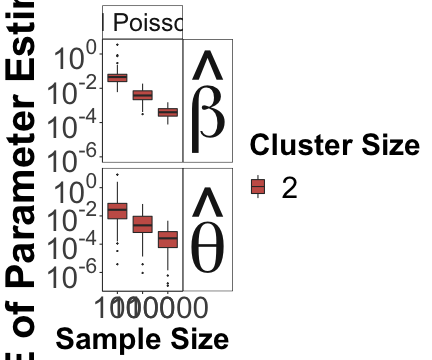

RObject{VecSxp}


In [8]:
### working on figure next
@rput msedfR

R"""
library(scales)
library(ggplot2)
library(data.table)

msedfR = data.table(msedfR)

msedfR[parameters == "beta",y_min := 10^-6]
msedfR[parameters == "beta",y_max := 10^0]
msedfR[parameters == "theta",y_min := 10^-5]
msedfR[parameters == "theta",y_max := 10^1]
# msedfR[parameters == "rho",y_min := 10^-9]
# msedfR[parameters == "rho",y_max := 10^-2]

#msedfR[parameters == "beta",y_min := 10^-8]
#msedfR[parameters == "beta",y_max := 10^-2]
#msedfR[parameters == "tau",y_min := 10^-8]
#msedfR[parameters == "tau",y_max := 10^-2]
#msedfR[parameters == "Sigma",y_min := 10^-5]
#msedfR[parameters == "Sigma",y_max := 10^-2]


msedfR$obssize = factor(msedfR$obssize, levels = c('2'))
msedfR$samplesize = factor(msedfR$samplesize, levels = c('100', '1000', '10000'))
msedfR$parameters = factor(msedfR$parameters, levels = c('beta', 'theta'), labels = c(beta = expression(hat(bold(beta))), theta = expression(hat(bold(theta)))))
msedfR$robust = factor(msedfR$robust, levels = c('Bivariate Mixed Poisson Bernoulli QC'),
    labels = c(expression(paste("Bivariate Mixed Poisson Bernoulli QC")))) # , expression(paste("MvT Gamma Inverse-Gamma"))))


#mseplot <- ggplot(msedfR[msedfR$mse < 10^0, ], aes(x=samplesize, y=mse, fill=obssize)) + 
mseplot = ggplot(msedfR[msedfR$mse < 10^3, ], aes(x=samplesize, y=mse, fill=obssize)) + 
  #geom_boxplot(outlier.size = 0.0, outlier.alpha = 0) +
  geom_boxplot(outlier.size = 0.25) +
#    geom_violin() +
    facet_grid(parameters ~ robust, labeller = label_parsed, scales = "free_y") +
  theme(legend.position="right", legend.key = element_blank(), axis.text.x = element_text(angle=0, size=30),
        axis.text.y = element_text(angle=0, size=30), axis.title.x = element_text(size = 30, face="bold"), 
        axis.title.y = element_text(size = 40, face="bold"), legend.title = element_text(size = 30, face="bold"),
        panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
        legend.text=element_text(size=30), panel.background = element_rect(fill = NA, color = "black"),
        #panel.background = element_blank(), #panel.border = element_blank(),
        axis.line = element_line(color = 'black',size=0.3), plot.title = element_text(hjust = 0.5),
        strip.background = element_rect(colour="black", fill="white"), strip.text.y = element_text(angle = 0, size=75, face="bold"),
        strip.text.x = element_text(size=25)) + 
  scale_fill_manual(values = c("#c85f55")) +
#scale_y_log10(breaks = scales::trans_breaks("log10", function(x) 10^x)) +
#scale_y_log10(breaks = 10^(-8:8), limit=c(10^-8, 10^2)) + 
scale_y_log10(breaks = 10^seq(-10, 10, 2), labels=trans_format("log10", math_format(10^.x))) + #, limit=c(10^-8, 10^2)) +
  labs(x = "Sample Size", y = "MSE of Parameter Estimates", fill = "Cluster Size") +
geom_blank(aes(y = y_max)) + 
geom_blank(aes(y = y_min)) 
"""

In [9]:
R"""
    ggsave('updated_msefacetplot_biv_mixed_poisson_bernoulli.png', mseplot, width = 20, height = 15, units = 'in', dpi = 450)
"""

RObject{StrSxp}
[1] "updated_msefacetplot_biv_mixed_poisson_bernoulli.png"
